In [ ]:
# Hourly Sales
## Import necessary libraries
import warnings
warnings.filterwarnings("ignore")
# sales_weather_pipeline.py
import pandas as pd
import numpy as np
from datetime import time
import pytz
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder

# ───────────────────────────────────────────────────────────────────────────────
# 1) CONFIGURE YOUR LOCAL FILE PATHS
# ───────────────────────────────────────────────────────────────────────────────
MASTER_STORE_CSV = r" ... csv"
SALES_CSV        = r" ... csv"
WEATHER_CSV      = r" ... csv"

# ───────────────────────────────────────────────────────────────────────────────
# 2) LOAD & PARSE MASTER STORE (Operating_Hours → Start_h, End_h)
# ───────────────────────────────────────────────────────────────────────────────
m = pd.read_csv(MASTER_STORE_CSV, dtype={"Store_No": str})
# split "6:00 AM - 12:00 AM"
oh = m["Operating_Hours"].str.split(" - ", expand=True)
m["Start_h"] = pd.to_datetime(oh[0], format="%I:%M %p").dt.hour
m["End_h"]   = pd.to_datetime(oh[1], format="%I:%M %p").dt.hour

# ───────────────────────────────────────────────────────────────────────────────
# 3) FILTER OUT OUTLIERS
# ───────────────────────────────────────────────────────────────────────────────
# Filtering outliers
m["Opening_Date"] = pd.to_datetime(m["Opening_Date"], format="%d-%m-%Y")

# 1. Closed stores: where CLOSEDATE is NOT null (i.e. already closed)
closed_stores = m[m["CLOSEDATE"].notna()]["Store_No"].astype(str)

# 2. Not open yet: where Opening_Date is in the future
today = pd.Timestamp.today().normalize()
not_open_yet = m[m["Opening_Date"] > today]["Store_No"].astype(str)

# 3. Empty Name: where Name is missing or blank
empty_name = m[m["Name"].isna() | (m["Name"].str.strip() == "")]["Store_No"].astype(str)

# Combine all outlier Store_Nos and changing to integer
outliers = pd.concat([closed_stores, not_open_yet, empty_name]).unique().tolist()
outliers_int = set(int(x) for x in outliers)
m = m[~m["Store_No"].astype(int).isin(outliers_int)]

# ───────────────────────────────────────────────────────────────────────────────
# 4) EXPAND EACH STORE INTO ITS OPERATING HOURS
# ───────────────────────────────────────────────────────────────────────────────
m.loc[m["End_h"] == 0.0, "End_h"] = 24.0

rows = []

m = m.dropna(subset=["Start_h", "End_h"])
for _, row in m.iterrows():
    s = int(row["Store_No"])
    start = int(row["Start_h"])
    end = int(row["End_h"])

    if start < end:
        hours = range(start, end + 1)  # normal hours, e.g. 8 to 17
    else:
        # overnight hours, e.g. 20 to 5 → 20, 21, 22, 23, 0, 1, ..., 5
        hours = list(range(start, 24)) + list(range(0, end + 1))

    for h in hours:
        rows.append({
            "Store_No": s,
            "Hour": h,
            "Start_h": start,
            "End_h": end
        })

map_df = pd.DataFrame(rows)

# ───────────────────────────────────────────────────────────────────────────────
# 5) LOAD & FILTER SALES (May 2025)
# ───────────────────────────────────────────────────────────────────────────────
sales = pd.read_csv(SALES_CSV, parse_dates=["Hourly Sales - Store & VM[Date]"])
sales.rename(columns={
    "Hourly Sales - Store & VM[Date]": "Date",
    "Hourly Sales - Store & VM[Store No]": "Store_No",
    "Hourly Sales - Store & VM[Hour]": "Hour",
    "Hourly Sales - Store & VM[Net Amount]": "Net_Amount",
    "Hourly Sales - Store & VM[TC]": "TC"
}, inplace=True)

#print("sales: ",len(sales))  # correct - 334565

## Keep only rows where Store_No is purely numeric - V is for vending machines
# Clean, then filter
sales["Store_No"] = sales["Store_No"].astype(str).str.strip()

# Filter purely numeric store numbers
sales_stores = sales[sales["Store_No"].str.fullmatch(r"\d+")].copy()

#print("Unique Store_No (after numeric filter):", sales_stores["Store_No"].nunique())        #correct - 450 

# Convert to integer after filtering
sales_stores["Store_No"] = sales_stores["Store_No"].astype(int) 

#print("Unique Store_No (after int cast):", sales_stores["Store_No"].nunique()) #correct - 450 

# Convert to datetime objects
sales_stores["Date"] = pd.to_datetime(sales_stores["Date"], format="%d/%m/%Y")

# Change columns to desired object types
sales_stores["Hour"] = sales_stores["Hour"].astype(int)
sales_stores["Net_Amount"] = sales_stores["Net_Amount"].astype(float)
sales_stores["TC"] = sales_stores["TC"].astype(int)

# Obtain only May 2025 data
sales_stores = sales_stores[
    (sales_stores["Date"] >= "2025-05-01") &
    (sales_stores["Date"] <  "2025-06-01")
].copy()

#print("Unique Store_No (May only):", sales_stores["Store_No"].nunique())  #correct - 450

# ───────────────────────────────────────────────────────────────────────────────
# 6) JOIN SALES → HOURS & FILTER OUT-OF-WINDOW
# ───────────────────────────────────────────────────────────────────────────────
sales_stores = sales_stores.merge(map_df, on=["Store_No", "Hour"], how="left")

#print("sales_stores 1: ",len(sales_stores)) # correct - 267606

# filter out datapoints not in operating hours
def in_operating_hours(row):
    hour = row["Hour"]
    start = row["Start_h"]
    end = row["End_h"]
    
    if pd.isna(start) or pd.isna(end):
        return False  # exclude if no mapping

    if start < end:
        return (start <= hour < end)  # exclude values before start and at/after end
    else:
        return (hour >= start or hour < end)  # wrap-around case

# Apply row-wise
sales_stores_filtered = sales_stores[sales_stores.apply(in_operating_hours, axis=1)].copy()
#print("Filtered in-window rows:", len(sales_stores_filtered))       #correct 260229

# ───────────────────────────────────────────────────────────────────────────────
# 7) LOAD & PARSE WEATHER (to local SG time → Date, Hour)
# ───────────────────────────────────────────────────────────────────────────────
wx = pd.read_csv(WEATHER_CSV)
wx["ts_utc"] = pd.to_datetime(wx["Timestamp"].str.strip(), format="%Y-%m-%d %H:%M:%S%z", utc=True)
wx["ts_sg"]  = wx["ts_utc"].dt.tz_convert("Asia/Singapore")
wx["Date"]   = wx["ts_sg"].dt.date
wx["Hour"]   = wx["ts_sg"].dt.hour
wx["Store_No"] = wx["Store No"].astype(int)
wx = wx[["Date","Hour","Store_No","Weather Code","Weather Description","Temperature (°C)"]]
wx = wx[
    (wx["Date"] >= pd.to_datetime("2025-05-01").date()) &
    (wx["Date"] <  pd.to_datetime("2025-06-01").date())
].copy()

# ───────────────────────────────────────────────────────────────────────────────
# 8) MERGE SALES ↔ WEATHER
# ───────────────────────────────────────────────────────────────────────────────
sales_stores_filtered["Date"] = pd.to_datetime(sales_stores["Date"])
wx["Date"] = pd.to_datetime(wx["Date"])

df = sales_stores_filtered.merge(
    wx,
    on=["Date","Store_No","Hour"],
    how="left"
).rename(columns={
    "Net Amount": "Net_Amount",
    "Weather Code":"Weather_Code",
    "Weather Description":"Weather_Description",
    "Temperature (°C)":"Temperature"
})
df["Net_Amount"] *= -1

# ───────────────────────────────────────────────────────────────────────────────
# 9) CORRELATION
# ───────────────────────────────────────────────────────────────────────────────
# numeric only: Net_Amount, TC, Weather_Code, Temperature
corr_pairs = [
    ("Net_Amount","Weather_Code"),
    ("Net_Amount","Temperature"),
    ("TC","Weather_Code"),
    ("TC","Temperature"),
]
print("\nPearson correlations:")
for x,y in corr_pairs:
    print(f"  {x} vs {y}: {df[x].corr(df[y]):.3f}")

print(" Conclusion: Weak positive correlation between Sales (Net Amount and TC) against Temperature.")

# ───────────────────────────────────────────────────────────────────────────────
# 10) ONE HOT ENCODING FOR WEATHER CODE
# ───────────────────────────────────────────────────────────────────────────────
# sample columns
df_encoded = pd.get_dummies(df, columns=["Weather_Code"], prefix="wc")

results = []

for col in df_encoded.columns:
    if col.startswith("wc_"):
        r_net = df_encoded[col].corr(df_encoded["Net_Amount"])
        r_tc  = df_encoded[col].corr(df_encoded["TC"])
        results.append({
            "Weather_Code": col.replace("wc_", ""),
            "Corr_with_Net_Amount": r_net,
            "Corr_with_TC": r_tc
        })

correlation_df = pd.DataFrame(results)
print(correlation_df.sort_values(by="Corr_with_Net_Amount", ascending=False))
print("Conclusion: Weather Code has little to no effect to Sales.")

In [2]:
# ───────────────────────────────────────────────────────────────────────────────
# 11) LINEAR REGRESSION MODELS
# ───────────────────────────────────────────────────────────────────────────────
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
# drop any rows with missing values
df_ml = df.dropna(subset=["Net_Amount","TC","Temperature","Hour"])
X = df_ml[["Temperature","Hour"]].values
y_net = df_ml["Net_Amount"].values
y_tc  = df_ml["TC"].values

# split 80/20 - 80 for training, 20 for test
Xtr, Xte, ynet_tr, ynet_te, ytc_tr, ytc_te = train_test_split(
    X, y_net, y_tc, test_size=0.2, random_state=42
)

# Model A: Net_Amount
lr1 = LinearRegression()
lr1.fit(Xtr, ynet_tr)
p_net = lr1.predict(Xte)
print("\nModel Net_Amount:")

coef1 = dict(zip(["Temperature", "Hour"], lr1.coef_))
for feature, value in coef1.items():
    print(f"  {feature}: {value:.4f}")

print("  intercept:", lr1.intercept_)
rmse_net_amount = np.sqrt(mean_squared_error(ynet_te, p_net))
print(" RMSE:", rmse_net_amount)
print("  R²:  ", r2_score(ynet_te, p_net))

# Model B: TC
lr2 = LinearRegression()
lr2.fit(Xtr, ytc_tr)
p_tc = lr2.predict(Xte)
print("\nModel TC:")

coef2 = dict(zip(["Temperature","Hour"], lr2.coef_))
for feature, value in coef2.items():
    print(f"  {feature}: {value:.4f}")

print("  intercept:", lr2.intercept_)
rmse_tc = np.sqrt(mean_squared_error(ytc_te, p_tc))
print(" RMSE:", rmse_tc)
print("  R²:  ", r2_score(ytc_te, p_tc))


Model Net_Amount:
  Temperature: 1.6682
  Hour: 19.9393
  intercept: 91.60961312356608
 RMSE: 246.97286483855052
  R²:   0.20509175208723973

Model TC:
  Temperature: 0.4714
  Hour: 1.0518
  intercept: -0.20911073247273393
 RMSE: 18.28180321046031
  R²:   0.12867017455804408


In [3]:
# ───────────────────────────────────────────────────────────────────────────────
# 12) LINEAR, RIDGE, LASSO, ELASTICNET REGRESSION MODELS
# ───────────────────────────────────────────────────────────────────────────────
# — Assumes df_ml already exists with 'Temperature', 'Hour', 'Net_Amount' —
# Create the interaction term
df_ml['Temp_Hour'] = df_ml['Temperature'] * df_ml['Hour']

# Define target variable
y = df_ml['Net_Amount'].values

# Define feature sets
feature_sets = {
    'Base': ['Temperature', 'Hour'],
    'With Interaction': ['Temperature', 'Hour', 'Temp_Hour']
}

# Define models including ElasticNet
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0), # Penalises large weights
    'Lasso': Lasso(alpha=0.1), # Can zero out irrelevant features
    'ElasticNet': ElasticNet(alpha=1.0, l1_ratio=0.5)  # adjust alpha and l1_ratio as needed, basically Ridge + Lasso
}

# Collect results
results = []

for scaler_name, use_scaling in [('No Scaling', False), ('StandardScaler', True)]:
    for fs_name, features in feature_sets.items():
        X = df_ml[features].values
        Xtr, Xte, ytr, yte = train_test_split(
            X, y, test_size=0.2, random_state=42
        )
        
        if use_scaling:
            scaler = StandardScaler()
            Xtr = scaler.fit_transform(Xtr)
            Xte = scaler.transform(Xte)
        
        for model_name, model in models.items():
            # fit & evaluate
            model.fit(Xtr, ytr)
            ypred = model.predict(Xte)
            rmse = np.sqrt(mean_squared_error(yte, ypred))
            r2  = r2_score(yte, ypred)
            
            results.append({
                'Scaler':      scaler_name,
                'Feature_Set': fs_name,
                'Model':       model_name,
                'RMSE':        rmse,
                'R2':          r2
            })

# Convert to DataFrame and display
df_results = pd.DataFrame(results)
print("Linear Models for predicting Net Amount")
print(df_results)

# Determine and print the best model (lowest RMSE, highest R² as tiebreaker)
best_idx = df_results['RMSE'].idxmin()
best = df_results.loc[best_idx]
print(f"\nBest model: {best['Model']} ({best['Scaler']}, {best['Feature_Set']}) "
      f"with RMSE = {best['RMSE']:.3f} and R² = {best['R2']:.3f}")


Linear Models for predicting Net Amount
            Scaler       Feature_Set             Model        RMSE        R2
0       No Scaling              Base  LinearRegression  246.972865  0.205092
1       No Scaling              Base             Ridge  246.972865  0.205092
2       No Scaling              Base             Lasso  246.973057  0.205091
3       No Scaling              Base        ElasticNet  246.974473  0.205081
4       No Scaling  With Interaction  LinearRegression  246.961481  0.205165
5       No Scaling  With Interaction             Ridge  246.961479  0.205165
6       No Scaling  With Interaction             Lasso  246.960390  0.205172
7       No Scaling  With Interaction        ElasticNet  246.963610  0.205151
8   StandardScaler              Base  LinearRegression  246.972865  0.205092
9   StandardScaler              Base             Ridge  246.972862  0.205092
10  StandardScaler              Base             Lasso  246.973158  0.205090
11  StandardScaler              Base

In [4]:
# — Assumes df_ml already exists with 'Temperature', 'Hour', 'Net_Amount' —
# Create the interaction term
df_ml['Temp_Hour'] = df_ml['Temperature'] * df_ml['Hour']

# Define target variable
y = df_ml['TC'].values

# Define feature sets
feature_sets = {
    'Base': ['Temperature', 'Hour'],
    'With Interaction': ['Temperature', 'Hour', 'Temp_Hour']
}

# Define models including ElasticNet
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0), # Penalises large weights
    'Lasso': Lasso(alpha=0.1), # Can zero out irrelevant features
    'ElasticNet': ElasticNet(alpha=1.0, l1_ratio=0.5)  # adjust alpha and l1_ratio as needed, basically Ridge + Lasso
}

# Collect results
results = []

for scaler_name, use_scaling in [('No Scaling', False), ('StandardScaler', True)]:
    for fs_name, features in feature_sets.items():
        X = df_ml[features].values
        Xtr, Xte, ytr, yte = train_test_split(
            X, y, test_size=0.2, random_state=42
        )
        
        if use_scaling:
            scaler = StandardScaler()
            Xtr = scaler.fit_transform(Xtr)
            Xte = scaler.transform(Xte)
        
        for model_name, model in models.items():
            # fit & evaluate
            model.fit(Xtr, ytr)
            ypred = model.predict(Xte)
            rmse = np.sqrt(mean_squared_error(yte, ypred))
            r2  = r2_score(yte, ypred)
            
            results.append({
                'Scaler':      scaler_name,
                'Feature_Set': fs_name,
                'Model':       model_name,
                'RMSE':        rmse,
                'R2':          r2
            })

# Convert to DataFrame and display
df_results = pd.DataFrame(results)
print("Linear Models for predicting TC")
print(df_results)

# Determine and print the best model (lowest RMSE, highest R² as tiebreaker)
best_idx = df_results['RMSE'].idxmin()
best = df_results.loc[best_idx]
print(f"\nBest model: {best['Model']} ({best['Scaler']}, {best['Feature_Set']}) "
      f"with RMSE = {best['RMSE']:.3f} and R² = {best['R2']:.3f}")

Linear Models for predicting TC
            Scaler       Feature_Set             Model       RMSE        R2
0       No Scaling              Base  LinearRegression  18.281803  0.128670
1       No Scaling              Base             Ridge  18.281803  0.128670
2       No Scaling              Base             Lasso  18.281927  0.128658
3       No Scaling              Base        ElasticNet  18.284498  0.128413
4       No Scaling  With Interaction  LinearRegression  18.279244  0.128914
5       No Scaling  With Interaction             Ridge  18.279244  0.128914
6       No Scaling  With Interaction             Lasso  18.279148  0.128923
7       No Scaling  With Interaction        ElasticNet  18.279649  0.128876
8   StandardScaler              Base  LinearRegression  18.281803  0.128670
9   StandardScaler              Base             Ridge  18.281803  0.128670
10  StandardScaler              Base             Lasso  18.282480  0.128606
11  StandardScaler              Base        ElasticNet  

XGBoost RMSE: 235.06
XGBoost R²:   0.2799


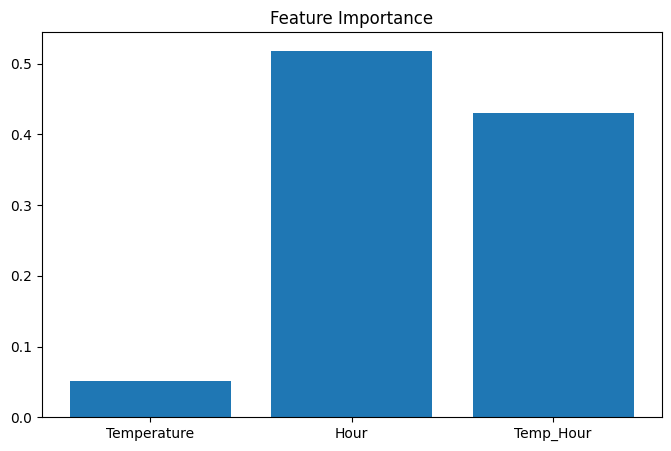

From this Feature Importance, we can see that Hour is the strongest predictor - time of day drives sales (expected).
We can also see that the interaction term is important - sales spike when hot at certain times.
Temperature is not very useful on its own. Good case where interaction term is impactful.
Train RMSE: 234.09  | Test RMSE: 235.06
Train R²:   0.2826  | Test R²:   0.2799
R² is < 0.3, model is weak - does not capture a lot of data. We want to find a model that ideally has R² of > 0.5.
RMSE: 235.06
Standard Deviation of Net_Amount: 277.01
RMSE is roughly 85% of Standard Deviation. This means that it is useful but not particularly strong/impactful. We want to find a model that ideally has RMSE to SD ratio of lower than 0.75.


In [5]:
# ───────────────────────────────────────────────────────────────────────────────
# 13) XGBOOST draft 1
# ───────────────────────────────────────────────────────────────────────────────
# 1. Imports
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

# 2. Prepare your data (based on your previous work)
df_ml = df.dropna(subset=["Net_Amount", "Temperature", "Hour"])

# Optional: Create interaction features
df_ml["Temp_Hour"] = df_ml["Temperature"] * df_ml["Hour"]

# Define features and target
features = ["Temperature", "Hour", "Temp_Hour"]
X = df_ml[features].values
y = df_ml["Net_Amount"].values

# 3. Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 4. Train XGBoost Regressor
xgb = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb.fit(X_train, y_train)

# 5. Predict & Evaluate
y_pred = xgb.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"XGBoost RMSE: {rmse:.2f}")
print(f"XGBoost R²:   {r2:.4f}")

# 6. Check Feature Importance
plt.figure(figsize=(8, 5))
xgb.feature_importances_
plt.bar(features, xgb.feature_importances_)
plt.title("Feature Importance")
plt.show()
print("From this Feature Importance, we can see that Hour is the strongest predictor - time of day drives sales (expected).")
print("We can also see that the interaction term is important - sales spike when hot at certain times.")
print("Temperature is not very useful on its own. Good case where interaction term is impactful.")

# 7. Compare train vs test to assess over/underfitting
train_rmse = np.sqrt(mean_squared_error(y_train, xgb.predict(X_train)))
train_r2 = r2_score(y_train, xgb.predict(X_train))

print(f"Train RMSE: {train_rmse:.2f}  | Test RMSE: {rmse:.2f}")
print(f"Train R²:   {train_r2:.4f}  | Test R²:   {r2:.4f}")
print("R² is < 0.3, model is weak - does not capture a lot of data. We want to find a model that ideally has R² of > 0.5.")

# Standard deviation of the true target
std_net = np.std(y_test)

print(f"RMSE: {rmse:.2f}")
print(f"Standard Deviation of Net_Amount: {std_net:.2f}")
print("RMSE is roughly 85% of Standard Deviation. This means that it is useful but not particularly strong/impactful. " 
      "We want to find a model that ideally has RMSE to SD ratio of lower than 0.75.")

#tune hyperparameters using gridsearchcv / optuna. Compare against linear/ridge/lasso models


In [6]:
# ───────────────────────────────────────────────────────────────────────────────
# 13) XGBOOST improved using GridSearchCV
# ───────────────────────────────────────────────────────────────────────────────
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd

# ----------------------------
# 1. Prepare your dataset
# ----------------------------
df_ml = df.dropna(subset=["Net_Amount", "Temperature", "Hour"])

# Optional interaction feature
df_ml["Temp_Hour"] = df_ml["Temperature"] * df_ml["Hour"]

# Define features and target
features = ["Temperature", "Hour", "Temp_Hour"]
X = df_ml[features].values
y = df_ml["Net_Amount"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ----------------------------
# 2. Define parameter grid
# ----------------------------
param_grid = {
    'n_estimators': [100, 300],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0, 0.1, 1],      # L1 regularization (sparsity)
    'reg_lambda': [1, 5, 10]       # L2 regularization (shrinkage)
}


# ----------------------------
# 3. Set up the model and GridSearch
# ----------------------------
model = XGBRegressor(random_state=42, n_jobs=-1)

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',  # RMSE (but negative for minimization)
    cv=5,
    verbose=1
)

grid_search.fit(X_train, y_train)

# ----------------------------
# 4. Print the best parameters and score
# ----------------------------
print("Best parameters:")
print(grid_search.best_params_)

print(f"\nBest CV RMSE: {-grid_search.best_score_:.2f}")

# ----------------------------
# 5. Evaluate on test set
# ----------------------------
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"\nTest RMSE: {rmse:.2f}")
print(f"Test R²: {r2:.4f}")

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best parameters:
{'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 10, 'subsample': 1.0}

Best CV RMSE: 234.03

Test RMSE: 234.74
Test R²: 0.2819


In [ ]:
# # Tasks ranked by priority: 
# 1. adjusting parameters of LinearRegression (in scikit learn) to attain a better linear regression (esp RMSE abit high for net amount one) - tried my best
# 2. explore lazypredict and find best models + tweak parameters (gets stuck at 26/42 already ran for more than 1 hour) 
# 3. attempt 4 different types of more advanced models: xgboost regressor, lightgbm, svr, neural network
# 4. can try find correlation of vending machine sales to weather - realised don't have vending machine location data so can't
# 5. request data for store type, e.g airport, store, gas station... and do clustering then find correlation against weather based on store type
# 6. look into holidays esp public holiday and correlation with weather, then if possible can look for school holidays, etc